In [3]:
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
file_data   = "/content/drive/My Drive/AssignmentFolder/Assignment09/mnist.csv"
handle_file = open(file_data, "r")
data        = handle_file.readlines()
handle_file.close()

size_row    = 28    # height of the image
size_col    = 28    # width of the image

num_image   = len(data)
count       = 0     # count for the number of images

#
# normalize the values of the input data to be [0, 1]
#
def normalize(data):

    data_normalized = (data - min(data)) / (max(data) - min(data))

    return(data_normalized)

#
# example of distance function between two vectors x and y
#
def distance(x, y):

    d = (x - y) ** 2
    s = np.sum(d)
    # r = np.sqrt(s)

    return(s)

#
# make a matrix each column of which represents an images in a vector form
#
list_image  = np.empty((size_row * size_col, num_image), dtype=float)
list_label  = np.empty(num_image, dtype=int)

for line in data:

    line_data   = line.split(',')
    label       = line_data[0]
    im_vector   = np.asfarray(line_data[1:])
    im_vector   = normalize(im_vector)

    list_label[count]       = label
    list_image[:, count]    = im_vector

    count += 1
"""
#
# plot first 150 images out of 10,000 with their labels
#
f1 = plt.figure(1)

for i in range(150):

    label       = list_label[i]
    im_vector   = list_image[:, i]
    im_matrix   = im_vector.reshape((size_row, size_col))

    plt.subplot(10, 15, i+1)
    plt.title(label)
    plt.imshow(im_matrix, cmap='Greys', interpolation='None')

    frame   = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)


#plt.show()

#
# plot the average image of all the images for each digit
#
f2 = plt.figure(2)

im_average  = np.zeros((size_row * size_col, 10), dtype=float)
im_count    = np.zeros(10, dtype=int)

for i in range(num_image):

    im_average[:, list_label[i]] += list_image[:, i]
    im_count[list_label[i]] += 1

for i in range(10):

    im_average[:, i] /= im_count[i]

    plt.subplot(2, 5, i+1)
    plt.title(i)
    plt.imshow(im_average[:,i].reshape((size_row, size_col)), cmap='Greys', interpolation='None')

    frame   = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)

plt.show()"""

"\n#\n# plot first 150 images out of 10,000 with their labels\n#\nf1 = plt.figure(1)\n\nfor i in range(150):\n\n    label       = list_label[i]\n    im_vector   = list_image[:, i]\n    im_matrix   = im_vector.reshape((size_row, size_col))\n\n    plt.subplot(10, 15, i+1)\n    plt.title(label)\n    plt.imshow(im_matrix, cmap='Greys', interpolation='None')\n\n    frame   = plt.gca()\n    frame.axes.get_xaxis().set_visible(False)\n    frame.axes.get_yaxis().set_visible(False)\n\n\n#plt.show()\n\n#\n# plot the average image of all the images for each digit\n#\nf2 = plt.figure(2)\n\nim_average  = np.zeros((size_row * size_col, 10), dtype=float)\nim_count    = np.zeros(10, dtype=int)\n\nfor i in range(num_image):\n\n    im_average[:, list_label[i]] += list_image[:, i]\n    im_count[list_label[i]] += 1\n\nfor i in range(10):\n\n    im_average[:, i] /= im_count[i]\n\n    plt.subplot(2, 5, i+1)\n    plt.title(i)\n    plt.imshow(im_average[:,i].reshape((size_row, size_col)), cmap='Greys', interpo

In [4]:
!curl https://colab.chainer.org/install | sh -
#cupy library를 사용하기 위해 사용

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1580  100  1580    0     0   3969      0 --:--:-- --:--:-- --:--:--  3969
+ apt -y -q install cuda-libraries-dev-10-0
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-10-0 is already the newest version (10.0.130-1).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.
+ pip install -q cupy-cuda100  chainer 
+ set +ex
Installation succeeded!


In [0]:

"""고침1"""
train_data = list_image[0:, 0:6000]
X_train = train_data

test_data = list_image[0:, 6000:10000]
X_test = test_data

"""추가1"""
#np.random.normal(loc = 0.0, scale = 0.5, size = (196, 784))
u = np.random.randn(196, 784)
v = np.random.randn(49, 196)
w = np.random.randn(10, 49)
#train
X = np.zeros((784, 1))
Y = np.zeros((196, 1))
Z = np.zeros((49, 1))
H = np.zeros((10, 1))
#test
x = np.zeros((784, 1))
y = np.zeros((196, 1))
z = np.zeros((49, 1))
h = np.zeros((10, 1))

In [0]:
def sigmoid (z):
    return 1 / (1 + np.exp(-z))
 
def sig_der(z):
    return (z*(1-z))

In [0]:
#구해야 하는 label
train_label = list_label[0:6000]
real_label = np.zeros((10, 6000))
#label
for i in range(0, 6000):
  for j in range(0, 10):
    if j == train_label[i]:
      real_label[j][i] = 1
    else:
      real_label[j][i] = 0

test_label = list_label[6000:10000]
test_real_label = np.zeros((10, 4000))
#test label
for i in range(0, 4000):
  for j in range(0, 10):
    if j == test_label[i]:
      test_real_label[j][i] = 1
    else:
      test_real_label[j][i] = 0

In [151]:
cycle = 30
learning_rate = 0.03
train_loss_list = []
test_loss_list = []

#accuracy
train_accuracy_list = []
test_accuracy_list = []
train_correct = 0
test_correct = 0

threshold = 0.00005

train_loss_list.append(0)
for j in range(cycle):
  for i in range(0, 6000):
    #use mini_batch
    X = X_train[0:, i:i+1]
    Y = sigmoid(cp.dot(u, X))
    Z = sigmoid(cp.dot(v, Y))
    H = sigmoid(cp.dot(w, Z))

    R = real_label[0:,i:i+1]
    #-값을 가지기도 해서 graph상에 표시할 때는 abs값 적용
    H_loss = H - R
    #to use backpropagation
    H_der = H_loss * sig_der(H)
    Z_loss = cp.dot(w.T, H_der)
    Z_der = Z_loss * sig_der(Z)
    Y_loss = cp.dot(v.T, Z_der)
    Y_der = Y_loss * sig_der(Y)

    tmpw = w - learning_rate * Z.T * H_der
    tmpv = v - learning_rate * Y.T * Z_der
    tmpu = u - learning_rate * X.T * Y_der
    if i < 3999 :
      #바꿔주기 전 test도 check

      x = X_test[0:, i: (i+1)]
      y = sigmoid(cp.dot(u, x))
      z = sigmoid(cp.dot(v, y))
      h = sigmoid(cp.dot(w, z))
      
      r = test_real_label[0:, i % 4000: (i + 1) % 4000]
      h_loss = h - r

      w = tmpw
      v = tmpv
      u = tmpu
      if test_real_label[h.argmax():h.argmax() + 1, i : (i + 1)] == 1:
        test_correct += 1

    if real_label[H.argmax():H.argmax() + 1 , i : i + 1] == 1:
      train_correct += 1

  train_loss_list.append(np.mean(np.abs(H_loss)))
  test_loss_list.append(np.mean(np.abs(h_loss)))
  if abs(train_loss_list[j] - train_loss_list[j + 1]) < threshold:
    print("converge")
    break
  print("cycle : ",j)
  train_accuracy_list.append(train_correct / 6000)
  test_accuracy_list.append(test_correct / 4000)
  train_correct = 0
  test_correct = 0

del train_loss_list[0]

cycle :  0
cycle :  1
cycle :  2
cycle :  3
cycle :  4
cycle :  5
cycle :  6
cycle :  7
cycle :  8
cycle :  9
cycle :  10
cycle :  11
cycle :  12
cycle :  13
cycle :  14
cycle :  15
cycle :  16
cycle :  17
cycle :  18
cycle :  19
cycle :  20
cycle :  21
cycle :  22
cycle :  23
cycle :  24
cycle :  25
cycle :  26
cycle :  27
cycle :  28
cycle :  29


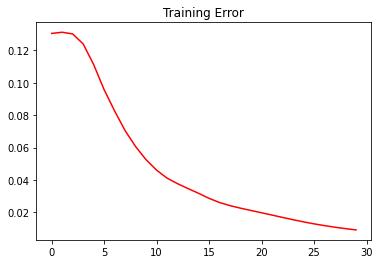

In [152]:

plt.plot(train_loss_list,c='red') #plot Training Error
plt.title('Training Error')
plt.show()

In [153]:
print(train_accuracy_list[len(train_accuracy_list) - 1])

0.9045


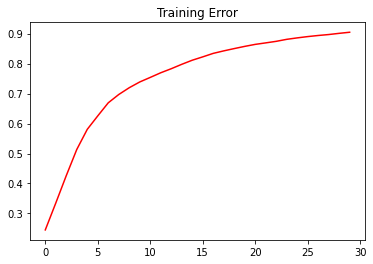

In [154]:
plt.plot(train_accuracy_list,c='red') #plot Training Error
plt.title('Training Error')
plt.show()

In [156]:
print(test_accuracy_list[len(test_accuracy_list) - 1])

0.81425


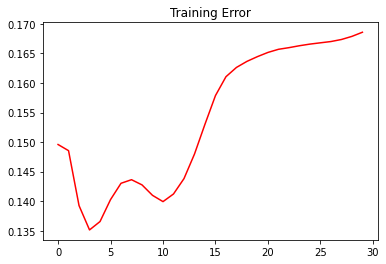

In [155]:

plt.plot(test_loss_list,c='red') #plot Training Error
plt.title('Training Error')
plt.show()

In [0]:
#.T붙여서 사용
"""고침1"""
train_data = list_image[0:, 0:6000]
X_train = train_data

test_data = list_image[0:, 6000:10000]
X_test = test_data

"""추가1"""
u = np.random.randn(196, 784)
v = np.random.randn(49, 196)
w = np.random.randn(10, 49)


In [0]:
#alpha 바꾸기 전 저장용
cycle = 30
learning_rate = 0.1
train_loss_list = []
#accuracy
correct = 0
train_accuracy_list = []




threshold = 0.00001

for j in range(cycle):
  for i in range(0, 6000):
    #use mini_batch
    X = X_train[i]
    Y = sigmoid(cp.dot(X, u))
    Z = sigmoid(cp.dot(Y, v))
    H = sigmoid(cp.dot(Z, w))

    r = np.zeros(10)
    r[y_train[i]] = 1.0

    H_loss = H - r
    #to use backpropagation
    H_der = H_loss * sigmoid_derivative(H)
    Z_loss = H_der.dot(w.T)
    Z_der = Z_loss * sigmoid_derivative(Z)
    Y_loss = Z_der.dot(v.T)
    Y_der = Y_loss * sigmoid_derivative(Y)

    tmpw = w - learning_rate * cp.reshape(Z, (-1, 1)) * H_loss
    tmpv = v - learning_rate * cp.reshape(Y, (-1, 1)) * Z_loss
    tmpu = u - learning_rate * cp.reshape(X, (-1, 1)) * Y_loss

    w = tmpw
    v = tmpv
    u = tmpu

    train_loss_list.append(np.mean(np.abs(H_loss)))
    if abs(train_loss_list[i - 1] - train_loss_list[i]) < threshold:
      break_check = True
      break
  print("cycle :",cycle)
  if break_check == True:
    break
#loss_Y = layer_3_delta.dot()


In [72]:
print(H.shape)

(10, 1)


In [0]:

#활성화 함수
def sigmoid(x):
    output = 1 / (1 + np.exp(-x))
    return output
 
def sigmoid_output_to_derivative(output):
    return sigmoid(output) * (1 - sigmoid(output))


In [0]:
X_train = list_image[:,0:6000].T
y_train = list_label[0:6000]

X_test = list_image[:,6000:10000].T
y_test = list_label[6000:10000]
# (784 - 196 - 49 - 10) 
theta_u = np.random.normal(loc=0.0, scale = 0.5, size = (784,196))
theta_v = np.random.normal(loc=0.0, scale = 0.5, size = (196,49))
theta_w = np.random.normal(loc=0.0, scale = 0.5, size = (49,10))

input_layer = np.zeros((1,784))
hidden_layer1 = np.zeros((1,196))
hidden_layer2 = np.zeros((1,49))
output_layer = np.zeros((1,10))

In [287]:
print(train_correct)

5953


In [314]:
cycle = 30 #cycle

learning_rate = 0.1 #learning rate = 0.1

tc_history = np.zeros(cycle) #training cost history

train_accuracy = np.zeros(cycle*len(X_test)) #training accuracy

#for check accuracy
train_correct = 0
train_incorrect =0

#define sigmoid function
def sigmoid (z):
    return 1 / (1 + np.exp(-z))
 
def sigmoid_derivative(z):
    return (z*(1-z))

for j in range(cycle):
    for i in range(len(X_train)):

        #input layer
        input_layer = X_train[i]
        #hidden layer1
        hidden_layer1 = sigmoid(cp.dot(input_layer,theta_u))
        #hidden layer2
        hidden_layer2 = sigmoid(cp.dot(hidden_layer1,theta_v))
        #output layer
        output_layer = sigmoid(cp.dot(hidden_layer2,theta_w))
 
        r=np.zeros(10)       #one hot encoding 
        r[y_train[i]] = 1.0    


        layer_3_error = output_layer - r
        layer_3_delta = layer_3_error*sigmoid_derivative(output_layer)            
            
        layer_2_error = layer_3_delta.dot(theta_w.T)
        layer_2_delta = layer_2_error * sigmoid_derivative(hidden_layer2)    
 
        layer_1_error = layer_2_delta.dot(theta_v.T)
        layer_1_delta = layer_1_error * sigmoid_derivative(hidden_layer1)
        
        #Back propagation
        theta_w -= learning_rate * cp.reshape(hidden_layer2,(-1,1))*layer_3_delta
        theta_v -= learning_rate * cp.reshape(hidden_layer1,(-1,1))*layer_2_delta
        theta_u -= learning_rate * cp.reshape(input_layer,(-1,1))*layer_1_delta

        #compare result
        if(output_layer.argmax(axis=0) == y_train[i]):
          train_correct+=1
        else:
          train_incorrect +=1
        
    train_accuracy[j]= train_correct/len(X_train)

    #check iteration & training error   
    print((j)," iterations:"  )
    tc_history[j] = np.mean(np.abs(layer_3_error))
    print("Error : {} , ACCURACY : {}".format(str(np.mean(np.abs(layer_3_error))),round(train_accuracy[j]*100,2)))

    train_correct = 0
    train_incorrect = 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


0  iterations:
Error : 0.05696179144013326 , ACCURACY : 85.22
1  iterations:
Error : 0.05299702205822669 , ACCURACY : 85.67
2  iterations:
Error : 0.05125692802983402 , ACCURACY : 85.9
3  iterations:
Error : 0.049847120825626035 , ACCURACY : 86.05
4  iterations:
Error : 0.04873614525762273 , ACCURACY : 86.27
5  iterations:
Error : 0.04830733418618043 , ACCURACY : 86.33
6  iterations:
Error : 0.04836696924123933 , ACCURACY : 86.45
7  iterations:
Error : 0.04865245832536941 , ACCURACY : 86.6
8  iterations:
Error : 0.04881125696054718 , ACCURACY : 86.68
9  iterations:
Error : 0.04851433401407786 , ACCURACY : 86.78
10  iterations:
Error : 0.048139083805235725 , ACCURACY : 86.87
11  iterations:
Error : 0.047956315695156515 , ACCURACY : 86.95
12  iterations:
Error : 0.04784415218784757 , ACCURACY : 87.02
13  iterations:
Error : 0.047810525433320414 , ACCURACY : 87.15
14  iterations:
Error : 0.04786990780696859 , ACCURACY : 87.22
15  iterations:
Error : 0.04793460173143613 , ACCURACY : 87.28


In [0]:
#for accuracy
correct = 0
incorrect =0

test_accuracy = np.zeros(len(X_test))
 
for i in range(len(X_test)):

    #feed forward
    layer_0 = X_test[i]
    layer_1 = sigmoid(cp.dot(layer_0,synapse_0))
    layer_2 = sigmoid(cp.dot(layer_1,synapse_1))
    layer_3 = sigmoid(cp.dot(layer_2,synapse_2))
 
    #for one hot encoding
    r = np.zeros(10)
    r[y_test[i]] = 1.0
    
    #compare result
    if(layer_3.argmax(axis=0) == y_test[i]):
        correct+=1
    else:
        incorrect +=1

    test_accuracy[i]= correct/len(X_test)

In [0]:
plt.plot(range(cycle),tc_history,c='red') #plot Training Error
plt.title('Training Error')
plt.show()

In [1]:
plt.plot(range(cycle),train_accuracy[:cycle],c='blue') #plot Training accuracy
plt.title('Training Accuracy')
plt.show()

NameError: ignored

In [220]:
#활성화 함수

train_cost_list = []
train_accuracy_list = []

iter = 0
for iter in range(0, 1000):
  #bias 추가해줄 곳
  layer0 = X
  layer1 = sigmoid(cp.dot(u, layer0))
  layer2 = sigmoid(cp.dot(v, layer1))
  layer3 = sigmoid(cp.dot(w, layer2))


  r = real_label
  #(10, 6000)
  layer3_error = layer3 - r
  cost_list.append(np.mean(layer3_error))
  #(10, 6000)
  layer3_delta = layer3_error * sigmoid_output_to_derivative(layer3)
  #(49, 6000)
  layer2_error = cp.dot(w.T, layer3_delta)
  #(49, 6000)
  layer2_delta = layer2_error * sigmoid_output_to_derivative(layer2)
  #(196, 6000)
  layer1_error = cp.dot(v.T, layer2_delta)
  #(196, 6000)
  layer1_delta = layer1_error * sigmoid_output_to_derivative(layer1)

  tmpw = w - alpha * cp.dot(layer3_delta, layer2.T)
  tmpv = v - alpha * cp.dot(layer2_delta, layer1.T)
  tmpu = u - alpha * cp.dot(layer1_delta, layer0.T)

  w = tmpw
  v = tmpv
  u = tmpu

  if iter % 100 == 0:
    print(iter)


0
100


KeyboardInterrupt: ignored

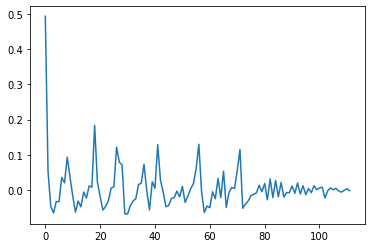

In [221]:
plt.plot(cost_list)
plt.show()

In [4]:
correct = 0

y = list_label[0:6000]

#for i in range(0, 6000):
#  if y[i] == layer3[0:, i:i+1].argmax():
#    correct += 1
for i in range(0, 6000):
  if real_label[layer3[0:,i:i+1].argmax()][i] == 1:
    correct += 1
#print(real_label.shape)
#print(layer3[0:, 0:1].argmax())
print(correct)

NameError: ignored

In [0]:
 #evaluate

#테스트 데이터도 0~1 사이의 값으로 변환
x = np.array(t_x)
X = (x/255.0)
 
correct = 0
incorrect =0
 
map = np.zeros((10,10))    #heatmap : map[ 정답 ][ 출력 ] += 1
map = map.astype(np.int32)
 
for i in range(len(X)):
    #feed forward
    layer_0 = X[i]
    layer_1 = sigmoid(np.dot(layer_0,synapse_0))
    layer_2 = sigmoid(np.dot(layer_1,synapse_1))
    layer_3 = sigmoid(np.dot(layer_2,synapse_2))
 
    r = np.zeros(10)
    r[t_y[i]] = 1.0
 
    #print("out:",X[i],":", layer_3)
    #print("out:",layer_3)    
    #print("out:",layer_3.argmax(axis=0) )
    #print("answer:",t_y[i])
    
    #output과 정답을 비교
    if(layer_3.argmax(axis=0) == t_y[i]):
        correct+=1
    else:
        incorrect +=1
 
    map[ t_y[i] ][ layer_3.argmax(axis=0) ] += 1
 
 
print(times," times ")
print("correct ratio = ", correct,"/",len(X) )
print("learning time: ",(end-start) )
print(map)
 
 
#for confusion matrix
map = map.astype(np.float64)
for i in range(10):
    map[i] = map[i] / np.sum(map[i])
 
#matplot show
plt.figure()
plt.imshow(map, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("MNIST  ratio : "+str(correct)+str("/")+str(len(X)) )
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks( range(10))
plt.yticks( range(10))
plt.tight_layout()
plt.ylabel('answer')
plt.xlabel('output')
 
plt.show()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1580  100  1580    0     0  12061      0 --:--:-- --:--:-- --:--:-- 12153
+ apt -y -q install cuda-libraries-dev-10-0
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-10-0 is already the newest version (10.0.130-1).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.
+ pip install -q cupy-cuda100  chainer 
     |████████████████████████████████| 335.2MB 48kB/s 
+ set +ex
Installation succeeded!


In [21]:
from torch import cuda

device = 'cuda' if cuda.is_available() else 'cpu'
print(f'Training MNIST Model on {device}\n{"="*44}')

Training MNIST Model on cuda


In [169]:
#np.random.normal() : 평균mean, 표준편차deriviation, size = (,)

#initialize + normalize
train_data = list_image[0:, 0:6000] / 255
print(train_data.shape)
print(len(train_data))
train_bias = np.ones((1, 6000))
#input data
#size : 784, 6000
X = train_data
#X bias
Xb = train_bias
#u for input data
u_d = np.random.randn(196, 784)
#u for input bias
u_b = np.random.randn(196,1)
#hidden layer1
#size : 784, 6000
Y = np.dot(u_d, X) + np.dot(u_b, Xb)
#activate
Y_ = 1 / (1 + np.exp(-Y))
#bias
Y_b = train_bias
#v for activate data Y_
v_d = np.random.randn(49, 196)
#v for bias Y_
v_b = np.random.randn(49, 1)

#hidden layer2
#size : 49, 6000
Z = np.dot(v_d, Y_) + np.dot(v_b, Y_b)
#activate
Z_ = 1 / (1 + np.exp(-Z))
#bias
Z_b = train_bias
#w for activate data Z_
w_d = np.random.randn(10, 49)
#w for bias Z_
w_b = np.random.randn(10, 1)
#deactivate output
H = np.dot(w_d, Z_) + np.dot(w_b, Z_b)
#activate
H_ = 1 / (1 + np.exp(-H))
print(H_)

learning_rate = 0.001



#test_data
#initialize + normalize
test_data = list_image[0:, 0:4000] / 255
test_bias = np.ones((1, 4000))
#input data
#size : 784, 4000
test_X = test_data
#X bias
test_Xb = test_bias

#hidden layer1
#size : 784, 4000
test_Y = np.dot(u_d, test_X) + np.dot(u_b, test_Xb)
#activate
test_Y_ = 1 / (1 + np.exp(-test_Y))
#bias
test_Y_b = test_bias

#hidden layer2
#size : 49, 4000
test_Z = np.dot(v_d, test_Y_) + np.dot(v_b, test_Y_b)
#activate
test_Z_ = 1 / (1 + np.exp(-test_Z))
#bias
test_Z_b = test_bias

#deactivate output
test_H = np.dot(w_d, test_Z_) + np.dot(w_b, test_Z_b)
#activate
test_H_ = 1 / (1 + np.exp(-test_H))


(784, 6000)
784
[[0.01295932 0.01221826 0.01264282 ... 0.01266073 0.01147457 0.01330153]
 [0.98022002 0.98162422 0.98012305 ... 0.97990923 0.98107712 0.97934552]
 [0.95529359 0.95907904 0.95889604 ... 0.9606163  0.95662846 0.95697647]
 ...
 [0.89153433 0.87923222 0.89669405 ... 0.88289208 0.88227866 0.89210334]
 [0.03729    0.03760552 0.03890924 ... 0.03538774 0.03803153 0.04073706]
 [0.68134536 0.68298886 0.70026949 ... 0.67243293 0.67911347 0.71110967]]


In [110]:
cost_list = []
test_cost_list = []
threshold = 0.000001
pre_cost = 0
#training accuracy
training_accuracy = []
testing_accuracy = []

iter = 0

while iter < 10000:
  
  #correct accuracy
  correct = 0
  testing_correct = 0

  #cost
  J = np.mean(-1 * real_label * np.log(H_) - (1 - real_label) * np.log(1 - H_))
  cost_list.append(J)
  #gradient descent
  tmp_w_d = w_d - learning_rate * np.dot(H_ - real_label, Z_.T)
  tmp_v_d = v_d - learning_rate * np.dot(np.dot(w_d.T, H_ - real_label) * Z_ * (1 - Z_), Y_.T)
  tmp_u_d = u_d - learning_rate * np.dot( np.dot(v_d.T, np.dot(w_d.T, H_ - real_label) * Z_ * (1 - Z_)) * Y_ * (1 - Y_), X.T )
  w_d = tmp_w_d
  v_d = tmp_v_d
  u_d = tmp_u_d
  #new layers
  Y = np.dot(u_d, X) + np.dot(u_b, Xb)
  Y_ = 1 / (1 + np.exp(-Y))
  Z = np.dot(v_d, Y_) + np.dot(v_b, Y_b)
  Z_ = 1 / (1 + np.exp(-Z))
  H = np.dot(w_d, Z_) + np.dot(w_b, Z_b)
  H_ = 1 / (1 + np.exp(-H))
      
  #test cost
  J_test = np.mean(-1 * test_real_label * np.log(test_H_) - (1 - test_real_label) * np.log(1 - test_H_))
  test_cost_list.append(J_test)
  #test_new layers
  test_Y = np.dot(u_d, test_X)
  test_Y_ = 1 / (1 + np.exp(-test_Y))
  test_Z = np.dot(v_d, test_Y_)
  test_Z_ = 1 / (1 + np.exp(-test_Z))
  test_H = np.dot(w_d, test_Z_)
  test_H_ = 1 / (1 + np.exp(-test_H))

  #training accuracy
  for i in range(0, 6000):
    if real_label[H_[0:,i:i+1].argmax()][i] == 1:
      correct += 1
  #testing accuracy
  for i in range(0, 4000):
    if test_real_label[test_H_[0:,i:i+1].argmax()][i] == 1:
      testing_correct += 1
  
  training_accuracy.append((correct / 6000) * 100)
  testing_accuracy.append((testing_correct / 4000) * 100)

  #is it converge?
  if abs(J - pre_cost) < threshold:
    print("converge at", iter)
    print(abs(J - pre_cost))
    break

  pre_cost = J

  if iter % 100 == 0:
    print(iter)

  iter += 1

0
100
200
300
400
500
600
700


KeyboardInterrupt: ignored

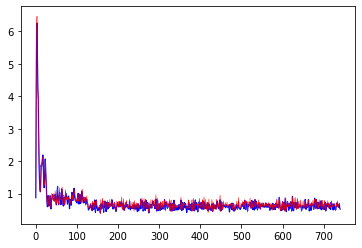

In [111]:
#training loss
plt.plot(cost_list, color = 'b',linewidth = 1.2)
plt.plot(test_cost_list, color = 'r', linewidth = 0.5)
plt.show()

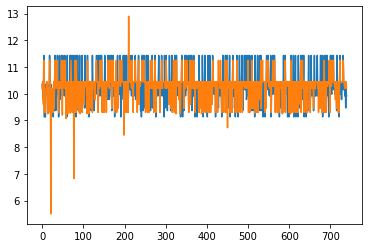

In [112]:
plt.plot(training_accuracy)
plt.plot(testing_accuracy)
plt.show()

In [113]:
print(training_accuracy[len(training_accuracy) - 1])
print(testing_accuracy[len(testing_accuracy) - 1])

9.916666666666666
10.2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in exp


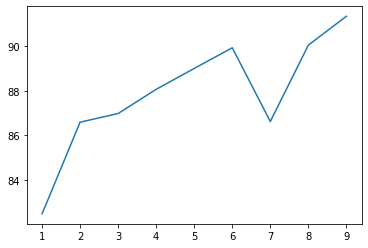

In [119]:
import numpy                    # 행렬 연산 등 외부 모듈 이용
import matplotlib.pyplot as plt # 이미지 출력 imshow 등 외부 모듈 이용
import cupy as cp
 
class MyNeuralNetwork:
    def __init__(self, inputNodesCnt, hiddenNodesCnt, outputNodesCnt, learningRate):
        self.inputNodesCnt  = inputNodesCnt     # 입력계층 노드 수
        self.hiddenNodesCnt = hiddenNodesCnt    # 은닉계층 노드 수
        self.outputNodesCnt = outputNodesCnt    # 출력계층 노드 수
        self.lr             = learningRate      # 학습률
        
        # numpy.random.normal 첫번째인자(0.0)를 중심, 두번째인자를 너비로하는 정규분포, 세번째인자를 크기로 생성한다.
        # 가중치(입력층 -> 은닉층): wih
        # 행렬 사이즈의 순서를 은닉, 입력 순으로 바꾼 이유는 아래 행렬 내적연산을 자연스럽게 하기 위해서이다.
        self.wih = numpy.random.normal(0.0, pow(self.hiddenNodesCnt, -0.5), (self.hiddenNodesCnt, self.inputNodesCnt))
        # 가중치(은닉층 -> 출력층): who
        self.who = numpy.random.normal(0.0, pow(self.outputNodesCnt, -0.5), (self.outputNodesCnt, self.hiddenNodesCnt))
        # 활성화함수 지정(여기서는 시그모이드함수 이용)
        self.activationFunc = lambda x: 1 / (1 + np.exp(-x))
        
    # 입력데이터와 정답라벨을 입력받아 학습한다.(마지막에 가중치 업데이트함을 주목하자)
    def train(self, inputsList, targetsList):
        # 가로로된 리스트를 2차원으로 변경하고 세로로 세운다.
        inputs = numpy.array(inputsList, ndmin=2).T
        
        # 가로로된 리스트를 2차원으로 변경하고 세로로 세운다.
        # targets는 출력계층 노드 수와 같고, 정답지에는 0.99 그렇지 않은 경우 0.01로 저장됨
        # 정답인 1개만 아주 크고 나머진 아주 작은 one-hot encoding으로 구성되어 있다.
        targets = numpy.array(targetsList, ndmin=2).T
        
        # [은닉계층 노드 수 X 입력계층 노드 수] 행렬과 [입력계층 노드 수 X 1] 행렬의 내적을 구한 후 활성화 함수 호출
        hiddenOutputs = self.activationFunc(cp.dot(self.wih, inputs))
        
        # [출력계층 노드 수 X 은닉계층 노드 수] 행렬과 [은닉계층 노드 수 X 1] 행렬의 내적을 구한 후 활성화 함수 호출
        # 출력계층에는 활성화 함수를 생략하기도 한다.
        hypothesis = self.activationFunc(cp.dot(self.who, hiddenOutputs))
        
        # 정답과 가정사이에 발생한 오차1(=비용)
        cost = targets - hypothesis        
        # (은닉게층 -> 출력계층) 가중치 업데이트
        self.who += self.lr * cp.dot((cost * hypothesis * (1.0 - hypothesis)), numpy.transpose(hiddenOutputs))
                
        # 은닉계층 -> 출력계층의 전치와 오차1의 내적을 통해 오차2 계산
        hiddenErrors = cp.dot(self.who.T, cost)        
        # (입력계층 -> 은닉계층) 가중치 업데이트
        self.wih += self.lr * cp.dot((hiddenErrors * hiddenOutputs * (1.0 - hiddenOutputs)), numpy.transpose(inputs))
    
    # 입력데이터를 신경망에 테스트하여 결과를 얻는다.
    def test(self, inputsList):
        # 가로로된 리스트를 2차원으로 변경하고 세로로 세운다.
        inputs = numpy.array(inputsList, ndmin=2).T
        
        # [은닉계층 노드 수 X 입력계층 노드 수] 행렬과 [입력계층 노드 수 X 1] 행렬의 내적을 구한 후 활성화 함수 호출
        hiddenOutputs = self.activationFunc(numpy.dot(self.wih, inputs))
        
        # [출력계층 노드 수 X 은닉계층 노드 수] 행렬과 [은닉계층 노드 수 X 1] 행렬의 내적을 구한 후 활성화 함수 호출
        return self.activationFunc(cp.dot(self.who, hiddenOutputs))
        
 
# 학습용(traing)데이터와 테스트용(test)데이터를 분리하여 준비
trainingDataFileHandler = open(file_data,"r")
# 학습용데이터를 읽어서 리스트형태로 저장
trainingDataList = trainingDataFileHandler.readlines()
# 학습용데이터 파일 핸들러를 닫는다.
trainingDataFileHandler.close()
 
 
testDataFileHandler = open(file_data,"r")
# 테스트용데이터를 읽어서 리스트형태로 저장
testDataList = testDataFileHandler.readlines()
# 테스트용데이터 파일 핸들러를 닫는다.
testDataFileHandler.close()
 
 
 
        
inputNodesCnt  = 784  # 입력계층 노드 수
hiddenNodesCnt = 100  # 은닉계층 노드 수
outputNodesCnt = 10   # 출력계층 노드 수
 
learningRate = 0.8    # 학습률
 
net = MyNeuralNetwork(inputNodesCnt, hiddenNodesCnt, outputNodesCnt, learningRate)
 
# 현재 스텝을 기록한다.
step = [];
# 현재 스텝의 정확도를 기록한다.
stepPerf = [];
 
for epochs in range(1, 10, 1):
    for e in range(epochs):
        for record in trainingDataList:
            # 한줄의 데이터를 읽어 쉼표를 구분자로 하여 여러 셀에 기록한다.
            cells = record.split(',')
            
            # 색상값이 0~255 사이 숫자이다.
            # 잘 학습할 수 있도록 0은 피하고 큰수를 피하기 위해 0.01 ~ 1.00 사이로 조정한다.
            inputs = (numpy.asfarray(cells[1:])/255.0*0.99) + 0.01
            
            # 정답인 1개만 아주 크고 나머진 아주 작은 one-hot encoding으로 구성되어 있다.
            targets = numpy.zeros(outputNodesCnt) + 0.01
            targets[int(cells[0])] = 0.99
            
            # 학습시킨다.
            net.train(inputs, targets)
            
    resultCard = []
 
    for record in testDataList:
        # 한줄의 데이터를 읽어 쉼표를 구분자로 하여 여러 셀에 기록한다.
        cells = record.split(',')
        # 첫번째 항목은 라벨링된 정답지이다.
        target = int(cells[0])
        
        # 색상값이 0~255 사이 숫자이다.
        # 잘 학습할 수 있도록 0은 피하고 큰수를 피하기 위해 0.01 ~ 1.00 사이로 조정한다.
        inputs = (numpy.asfarray(cells[1:])/255.0 * 0.99) + 0.01
        
        # 테스트 쿼리를 실행한다.
        outputs = net.test(inputs)
        # 배열중 최대값을 가진 인덱스를 반환한느 argmax를 통해 찾은 최대값과 정답지를 비교한다.
        if(numpy.argmax(outputs) == target):
            # 정답이라면 1 표시
            resultCard.append(1)
        else:
            # 오답이라면 0 표시
            resultCard.append(0)
            
    # resultCard 리스트를 배열형태로 변환한 후 평균을 구한다.
    perf = numpy.asarray(resultCard).mean() * 100.0
    
    # 현재 에폭을 step에 저장
    step.append(epochs);
    # 현재 에폭의 결과를 stepPerf에 저장
    stepPerf.append(perf);
    
    
    
plt.plot(step, stepPerf)
plt.show()
 

In [0]:

#training accuracy
training_accuracy = 0
testing_accuracy = 0

#correct accuracy
correct = 0
test_correct = 0

iter = 0
#real_label[H_[0:,iter:iter+1].argmax()][iter]

H_L = np.zeros((10, 6000))
while iter < 6000:
  #n번째가 label이 1이다.  
  for iter0 in range(0, 10):
    if iter0 == H_[0:,iter:iter+1].argmax():
      H_L[iter0][iter] = 1
  iter += 1

iter = 0
test_H_L = np.zeros((10, 4000))
while iter < 4000:
  #n번째가 label이 1이다.  
  for iter0 in range(0, 10):
    if iter0 == test_H_[0:,iter:iter+1].argmax():
      test_H_L[iter0][iter] = 1
  iter += 1

for i in range(0, 6000):
  for j in range(0, 10):
    if H_L[j][i] == 1 and real_label[j][i] == 1:
      correct += 1


for i in range(0, 4000):
  for j in range(0, 10):
    if test_H[j][i] == 1 and test_real_label == 1:
      test_correct += 1

training_accuracy = (correct / 6000) * 100
testing_accuracy = (test_correct / 4000) * 100


In [9]:
#784개가 있음 그것을 10개로 줄임
#그런게 10000개가 있는데 각각 0~1사이의 값을 가지게 됨
#그 값이 가장 큰 것이 label이고 원래의 label과 비교하면 됨
#6000개가 training 4000개가 testing


#u, v, w : weight


#normalization : 최대값 찾기

train_bias = np.ones((1, 6000))
test_bias = np.ones((1, 4000))


normal_image = list_image / 255


train_data = list_image[0:, 0:6000]
test_data = normal_image[0:, 6000:10000]


#label을 구하는 과정도 필요


#test_initialize
X = np.vstack([test_bias, test_data])
u = np.random.randn(196, 785)
print("X shape : ", X.shape)
Y = np.dot(u, X)

Y_ = 1 / (1 + np.exp(Y))
Y_ = np.vstack([test_bias, Y_])
print("Y_ shape : ", Y.shape)

v = np.random.randn(49, 197)

Z = np.dot(v, Y_)

Z_ = 1 / (1 + np.exp(Z))
Z_ = np.vstack([test_bias, Z_])
print("Z_ shape : ", Z.shape)

w = np.random.randn(10, 50)

H = np.dot(w, Z_)
H_ = 1 / (1 + np.exp(H))
print("H_ shape : ", H.shape)

#i는 어떤 label이 제일 큰지(그래서 어떤 라벨이 되었는지)를 나타낸다

iter = 0
iter0 = 0
#H_L : H의 label list
H_L = np.zeros((10, 4000))


#prediction

#label은 index maximum value
while iter < 4000:
  #n번째가 label이 1이다.  
  for iter0 in range(0, 10):
    if iter0 == H_[0:,iter:iter+1].argmax():
      H_L[iter0][iter] = 1
  iter += 1
print(H_L)
print(H_L.shape)



J_H = np.mean(-1 * H_L * np.log(H_) - (1 -H_L) * np.log(1 - H_))
print(J_H)

learning_rate = 0.0001
"""iter1 = 0
iter2 = 0
#bias는 어차피 1이므로 그냥 곱해도 상관없다

#w
for iter1 in range(0, 10):
  for iter2 in range(0, 50):
    w[iter1][iter2] -= learning_rate * np.mean((H_[iter1] - H_L[iter1]) * (Z_[iter2]))

#v
for iter3 in range(0, 49):
  for iter4 in range(0, 197):
    for iter1 in range(0, 10):
      v[iter3][iter4] -= learning_rate * np.mean( np.mean(w[iter1][iter3] * (H_[iter1] - H_L[iter1])) * Z_[iter3] * (1 - Z[iter3]) * Y_[iter4] )
#u
for
"""
#이래서 normalization이 필요한 거시다!
#w -= learning_rate * H_ - normal_image[6000:] 

#s구했으니 v도 구해야지
#v makes 197 to 49 so 49 * 197 and 
#we need  H and H_L values
#H : 10 * 4000 => use np.sum? because effect all factors

#v -= learning_rate * np.mean(    H_ - list_label[6000:] )

X shape :  (785, 4000)
Y_ shape :  (196, 4000)
Z_ shape :  (49, 4000)
H_ shape :  (10, 4000)
[[1. 1. 1. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(10, 4000)
1.7416012343432377


'iter1 = 0\niter2 = 0\n#bias는 어차피 1이므로 그냥 곱해도 상관없다\n\n#w\nfor iter1 in range(0, 10):\n  for iter2 in range(0, 50):\n    w[iter1][iter2] -= learning_rate * np.mean((H_[iter1] - H_L[iter1]) * (Z_[iter2]))\n\n#v\nfor iter3 in range(0, 49):\n  for iter4 in range(0, 197):\n    for iter1 in range(0, 10):\n      v[iter3][iter4] -= learning_rate * np.mean( np.mean(w[iter1][iter3] * (H_[iter1] - H_L[iter1])) * Z_[iter3] * (1 - Z[iter3]) * Y_[iter4] )\n#u\nfor\n'

In [0]:
#bias 제외하고 생각한 그림
#dot을 이용하기 위해 따로 떼고 생각
#bias는 나중에 계산한다

#이래서 normalization이 필요한 거시다!
#w : (10, 50) H_ : (10, 10000) normal_image : (784, 10000), Z :(50, 10000)
w -= learning_rate * np.dot(H_ - H_L, Z_.T) / 4000
#BIAS제외가 필요
v -= learning_rate * np.dot(np.dot(w.T[1:,], H_ - H_L) * Z_[1:,] * (1 - Z_[1:,]), Y_.T) / 4000
#u / 마찬가지로 bias제외
u -= learning_rate * np.dot( np.dot(v.T[1:,], np.dot(w.T[1:,], H_ - H_L) * Z_[1:,]* (1 - Z_[1:,])) * Y_[1:,] * (1 - Y_[1:,]), X.T )/ 4000

In [0]:
iter = 0
cost_list = []

while iter < 1000:
  Y = np.dot(u, X)

  Y_ = 1 / (1 + np.exp(Y))
  Y_ = np.vstack([test_bias, Y_])
  Z = np.dot(v, Y_)

  Z_ = 1 / (1 + np.exp(Z))
  Z_ = np.vstack([test_bias, Z_])

  H = np.dot(w, Z_)
  H_ = 1 / (1 + np.exp(H))

  J_H = np.mean(-1 * H_L * np.log(H_) - (1 - H_L) * np.log(1 - H_))
  cost_list.append(J_H)
  #동시에 update필요
  #w : (10, 50) H_ : (10, 10000) normal_image : (784, 10000), Z :(50, 10000)
  tmp_w = w - learning_rate * np.dot(H_ - H_L, Z_.T) / 4000
  #BIAS제외가 필요
  tmp_v = v - learning_rate * np.dot(np.dot(w.T[1:,], H_ - H_L) * Z_[1:,] * (1 - Z_[1:,]), Y_.T) / 4000
  #u / 마찬가지로 bias제외
  tmp_u = u - learning_rate * np.dot( np.dot(v.T[1:,], np.dot(w.T[1:,], H_ - H_L) * Z_[1:,]* (1 - Z_[1:,])) * Y_[1:,] * (1 - Y_[1:,]), X.T )/ 4000

  w = tmp_w
  v = tmp_v
  u = tmp_u

  iter += 1

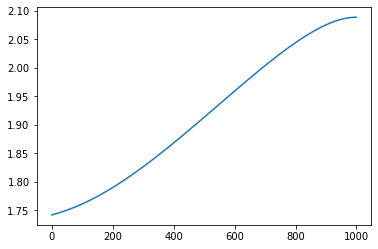

In [11]:

plt.plot(cost_list)
plt.show()

In [0]:
#1. sigmoid function에 대한 def sig():하나 만들고
#2. bias와 구분
#3. normalize
#4. test에 대한 label들 10 * 4000꼴로 만듦